In [39]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [40]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [41]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [42]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [43]:
from sqlalchemy.ext.automap import automap_base

# Declare a Base using automap_base()
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)  # Use the new parameter



In [44]:
# Print all of the classes mapped to the Base
for class_name in Base.classes.keys():
    print(class_name)



measurement
station


In [45]:
# Print all mapped class names to verify
print("Mapped Classes:", Base.classes.keys())


Mapped Classes: ['measurement', 'station']


In [46]:
from sqlalchemy.orm import Session

# Assign the measurement class to a variable called `Measurement`
Measurement = Base.classes.measurement  

# Assign the station class to a variable called `Station`
Station = Base.classes.station  

# Create a session
session = Session(bind=engine)

# Print the column names of the Measurement table
print("Measurement Class Columns:", Measurement.__table__.columns.keys())

# Print the column names of the Station table
print("Station Class Columns:", Station.__table__.columns.keys())



Measurement Class Columns: ['id', 'station', 'date', 'prcp', 'tobs']
Station Class Columns: ['id', 'station', 'name', 'latitude', 'longitude', 'elevation']


# Exploratory Precipitation Analysis

In [47]:
# Query to find the most recent date
most_recent_date = session.query(func.max(Measurement.date)).scalar()

# Print the most recent date
print(f"The most recent date in the dataset is: {most_recent_date}")



The most recent date in the dataset is: 2017-08-23


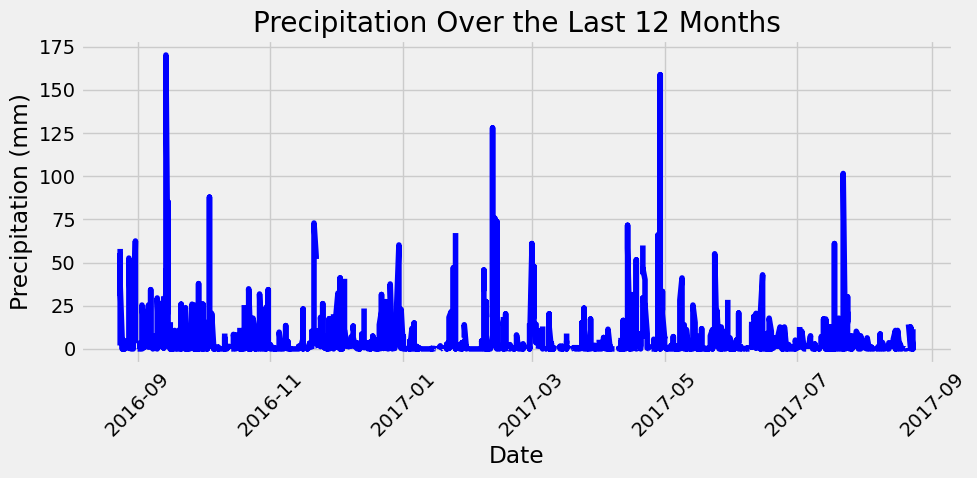

In [48]:
from datetime import datetime, timedelta
from sqlalchemy import func
import pandas as pd
import matplotlib.pyplot as plt


# Step 1: Find the most recent date
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date = datetime.strptime(most_recent_date, '%Y-%m-%d')

# Step 2: Calculate the date one year before the most recent date
one_year_ago = most_recent_date - timedelta(days=365)

# Step 3: Query to retrieve the last 12 months of precipitation data
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

# Step 4: Save the query results as a Pandas DataFrame
precipitation_df = pd.DataFrame(precipitation_data, columns=['date', 'precipitation'])

# Step 5: Convert 'date' column to datetime and sort the DataFrame by date
precipitation_df['date'] = pd.to_datetime(precipitation_df['date'])
precipitation_df.sort_values('date', inplace=True)

# Step 6: Plot the data
plt.figure(figsize=(10, 5))
plt.plot(precipitation_df['date'], precipitation_df['precipitation'], color='blue')
plt.title('Precipitation Over the Last 12 Months')
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


In [49]:
# Calculate summary statistics for the precipitation data
summary_statistics = precipitation_df['precipitation'].describe()

# Print the summary statistics
print("Summary Statistics for Precipitation Data:")
print(summary_statistics)



Summary Statistics for Precipitation Data:
count    2015.000000
mean        4.485112
std        11.690532
min         0.000000
25%         0.000000
50%         0.500000
75%         3.300000
max       170.200000
Name: precipitation, dtype: float64


# Exploratory Station Analysis

In [50]:
# Assuming you have the Station class mapped to Base.classes.station

# Query to calculate the total number of stations
total_stations = session.query(func.count(Station.station)).scalar()

# Print the total number of stations
print(f"The total number of stations in the dataset is: {total_stations}")



The total number of stations in the dataset is: 9


In [51]:


# Query to find the most active stations
active_stations = session.query(
    Measurement.station,
    func.count(Measurement.station).label('station_count')
).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

# Print the most active stations
print("Most Active Stations (Station and Count):")
for station, count in active_stations:
    print(f"Station: {station}, Count: {count}")


Most Active Stations (Station and Count):
Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [52]:
from sqlalchemy import func

# Query to find the most active stations and get the station with the highest count
active_stations = session.query(
    Measurement.station,
    func.count(Measurement.station).label('station_count')
).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

# Get the most active station ID (the station with the highest count)
most_active_station_id = active_stations[0][0]  # Extract the station ID from the first result

# Query to calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(
    func.min(Measurement.tobs).label('min_temp'),
    func.max(Measurement.tobs).label('max_temp'),
    func.avg(Measurement.tobs).label('avg_temp')
).filter(Measurement.station == most_active_station_id).all()

# Extract temperature statistics
min_temp, max_temp, avg_temp = temperature_stats[0]

# Print the results
print(f"Station ID: {most_active_station_id}")
print(f"Lowest Temperature: {min_temp}°F")
print(f"Highest Temperature: {max_temp}°F")
print(f"Average Temperature: {avg_temp:.2f}°F")


Station ID: USC00519281
Lowest Temperature: 12.2°F
Highest Temperature: 29.4°F
Average Temperature: 22.04°F


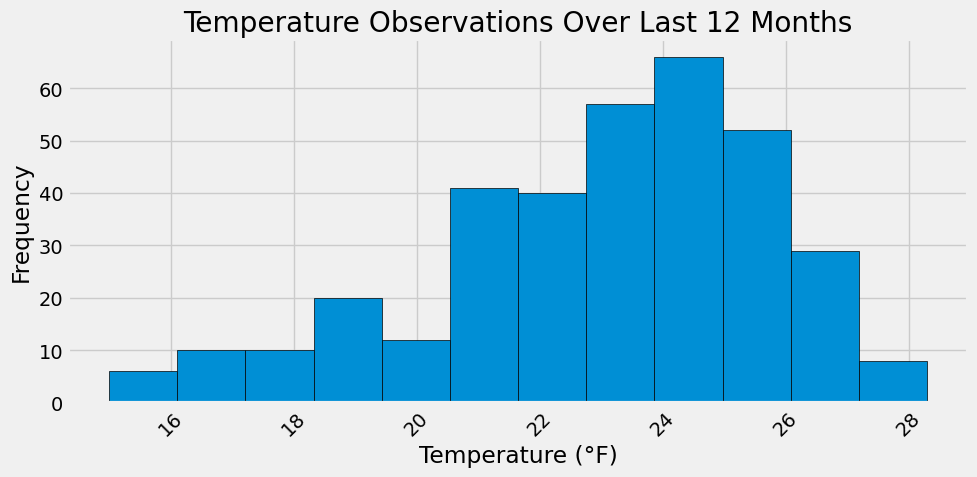

In [53]:
from sqlalchemy import func
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Query to find the most active stations and get the station with the highest count
active_stations = session.query(
    Measurement.station,
    func.count(Measurement.station).label('station_count')
).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

# Get the most active station ID (the station with the highest count)
most_active_station_id = active_stations[0][0]  # Extract the station ID

# Query to get the most recent date in the dataset
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date = datetime.strptime(most_recent_date, '%Y-%m-%d')

# Calculate the date one year ago from the most recent date
one_year_ago = most_recent_date - timedelta(days=365)

# Query the last 12 months of temperature observation data for the most active station
temperature_data = session.query(Measurement.tobs).filter(
    Measurement.station == most_active_station_id,
    Measurement.date >= one_year_ago
).all()

# Convert the results to a list of temperatures
temperature_list = [temp[0] for temp in temperature_data]

# Plot the results as a histogram
plt.figure(figsize=(10, 5))
plt.hist(temperature_list, bins=12, edgecolor='black')
plt.title('Temperature Observations Over Last 12 Months')  
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


# Close Session

In [38]:
# Close Session
session.close()
